In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(  # train_datagen
        '/content/drive/MyDrive/NEU_DET/Train_IMAGES',  # This is the source directory for training images
        target_size=(200,200),  # All images will be resized to 200 x 200
        color_mode='rgb',
        batch_size = 64,
        # Specify the classes explicitly
        classes = ['crazing','inclusion','patches','pitted_surface','rolled_in_scale','scratches'],
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/NEU_DET/Test_IMAGES',  # This is the source directory for training images
        target_size=(200,200),  # All images will be resized to 200 x 200
        color_mode='rgb', # grayscale, rgb
        batch_size = 64,  # 128, 64, 32, 24
        # Specify the classes explicitly
        classes = ['crazing','inclusion','patches','pitted_surface','rolled_in_scale','scratches'],
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Found 1464 images belonging to 6 classes.
Found 336 images belonging to 6 classes.


In [11]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(1024, activation='relu'),  # 1024, 128, 64, 32
    # 6 output neurons for 6 classes with the softmax activation
    tf.keras.layers.Dense(6, activation='sigmoid')  # softmax
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 198, 198, 16)      160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 64)       

In [3]:
# Image Detection Using the VGG-19 Convolutional Neural Network

# Build VGG19 structure
from tensorflow.keras.applications import VGG19

base_model = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=(200,200,3))

print('VGG19 Loaded')
print(base_model.summary())

VGG19 Loaded
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)

In [4]:
# Image Detection Using the VGG-19 Convolutional Neural Network
import tensorflow as tf

model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))  # 4096
model.add(tf.keras.layers.Dense(128, activation='relu'))  # 4096, 2048, 1024, 512
model.add(tf.keras.layers.Dense(6, activation='sigmoid'))  # softmax, sigmoid

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 22,401,094
Trainable params: 22,401,094
Non-trainable params: 0
_________________________________________________________________


In [5]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
history = model.fit(
        train_generator,
        validation_data = test_generator,
        epochs = 30)   #50

Epoch 1/30
23/23 [==============================] - 49s 2s/step - loss: 2.1309 - accuracy: 0.1578 - val_loss: 1.7615 - val_accuracy: 0.1667
Epoch 2/30
23/23 [==============================] - 23s 1s/step - loss: 1.6923 - accuracy: 0.2445 - val_loss: 1.4523 - val_accuracy: 0.5060
Epoch 3/30
23/23 [==============================] - 23s 1s/step - loss: 1.2542 - accuracy: 0.4727 - val_loss: 1.1918 - val_accuracy: 0.3690
Epoch 4/30
23/23 [==============================] - 24s 1s/step - loss: 0.9422 - accuracy: 0.5902 - val_loss: 0.9092 - val_accuracy: 0.6012
Epoch 5/30
23/23 [==============================] - 24s 1s/step - loss: 0.7927 - accuracy: 0.6660 - val_loss: 0.9854 - val_accuracy: 0.6012
Epoch 6/30
23/23 [==============================] - 23s 1s/step - loss: 0.6576 - accuracy: 0.7193 - val_loss: 0.9015 - val_accuracy: 0.5893
Epoch 7/30
23/23 [==============================] - 24s 1s/step - loss: 0.8092 - accuracy: 0.6626 - val_loss: 0.6737 - val_accuracy: 0.7589
Epoch 8/30
23/23 [==

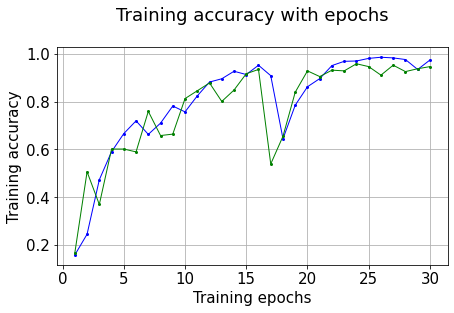

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(30)],history.history['accuracy'],'-o',c='b',lw=1,markersize=2)
plt.plot([i+1 for i in range(30)],history.history['val_accuracy'],'-o',c='g',lw=1,markersize=2)
plt.grid(True)
plt.title("Training accuracy with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
#from tqdm import tqdm

DATADIR = 'NEU_DET/Train_IMAGES'

CATEGORIES = ['crazing','inclusion','patches','pitted_surface','rolled_in_scale','scratches']

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    train_class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        
        train_img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)     # convert to array
        plt.imshow(train_img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

    
DATADIR = 'NEU_DET/Test_IMAGES'

CATEGORIES = ['crazing','inclusion','patches','pitted_surface','rolled_in_scale','scratches']

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    test_class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        
        test_img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)     # convert to array
        plt.imshow(test_img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!


In [ ]:
print(train_img_array[0])

In [ ]:
print(test_img_array.shape)

In [ ]:
from keras.utils import to_categorical

y_train = to_categorical(train_class_num)

print(y_train[6])

In [ ]:
import keras

X_train = train_img_array
y_train = keras.utils.to_categorical(X_train, class_num)

X_test = test_img_array
y_test = keras.utils.to_categorical(X_test, class_num)

In [ ]:
print(X_test[10])

In [ ]:
print(y_train[0])

In [ ]:
tf.keras.preprocessing.image_dataset_from_directory(
    'NEU_DET/Test_IMAGES',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(200, 200),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='categorical',
    follow_links=False,
)


In [ ]:
import tensorflow as tf

tf.keras.preprocessing.image.load_img(
    'NEU_DET/Test_IMAGES/crazing/crazing_218.jpg', 
    grayscale=True, 
    color_mode="grayscale", 
    target_size=None, 
    interpolation="categorical"
)


In [ ]:
image = tf.keras.preprocessing.image.load_img('NEU_DET/Test_IMAGES/crazing/crazing_218.jpg')
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)